In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shap
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA



In [2]:
# Load data
path = r"C:\Users\nnsan\Documents\Panel_Data_For Analysis.xlsx"  # Replace with your file path
data = pd.read_excel(path)  # Replace with your file path
data['CSD'] = data['Charging infrastructures'] / data['PD (Population/sqKM)']*100000  # Charger Density per 100,000 population per sqKM
data['Sub & Tax'] = data['Subsidies and Tax Exemption '].apply(lambda x: 1 if x == 'Yes' else 0)  # Convert to binary
# Filter 2015-2023 for completeness
data = data[(data['Year'] >= 2015) & (data['Year'] <= 2023)].dropna(subset=['EVAR (%)', 'CSD', 'RES (%)'])

In [3]:
# Construct Feasibility Score via PCA
pca_data = data[['EVAR (%)', 'CSD', 'RES (%)']]
scaler = StandardScaler()
pca_scaled = scaler.fit_transform(pca_data)
pca = PCA(n_components=1)
data['Feasibility_Score'] = pca.fit_transform(pca_scaled).flatten()
data['Feasibility_Score'] = MinMaxScaler(feature_range=(0, 100)).fit_transform(
    data[['Feasibility_Score']]
)  

# Features and target
X_= data[['EVAR (%)','CSD', 'GDP Per capita ($)', 'RES (%)','Access to Electricity (%)', 'Battery Cost ($)', 'Urbanization (%)', 'Sub & Tax']]
X = data[['CSD', 'GDP Per capita ($)', 'RES (%)', 'Access to Electricity (%)', 'Battery Cost ($)', 'Urbanization (%)', 'Sub & Tax']]
y = data['Feasibility_Score']






In [4]:
X_.corr()

,EVAR (%),CSD,GDP Per capita ($),RES (%),Access to Electricity (%),Battery Cost ($),Urbanization (%),Sub & Tax
EVAR (%),1.000000,0.837341,0.228102,-0.033952,0.417174,-1.232076e-01,0.232633,5.303947e-01
CSD,0.837341,1.000000,0.384931,0.008485,0.367145,-2.422745e-01,0.302309,4.710260e-01
GDP Per capita ($),0.228102,0.384931,1.000000,-0.005907,0.509874,-5.509219e-02,0.646895,6.490995e-01
RES (%),-0.033952,0.008485,-0.005907,1.000000,-0.384138,-7.004448e-02,-0.656002,-3.065222e-01
Access to Electricity (%),0.417174,0.367145,0.509874,-0.384138,1.000000,-1.183247e-01,0.850038,6.992884e-01
Battery Cost ($),-0.123208,-0.242274,-0.055092,-0.070044,-0.118325,1.000000e+00,-0.084189,5.698687e-16
Urbanization (%),0.232633,0.302309,0.646895,-0.656002,0.850038,-8.418907e-02,1.000000,7.036487e-01
Sub & Tax,0.530395,0.471026,0.649099,-0.306522,0.699288,5.698687e-16,0.703649,1.000000e+00


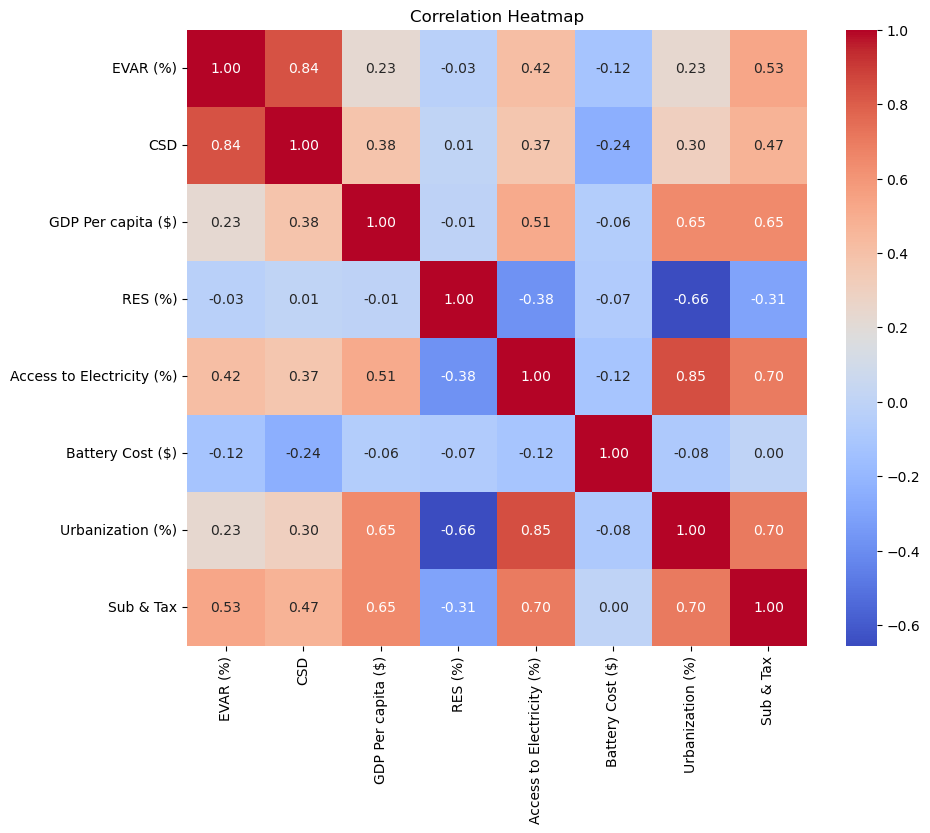

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(X_.corr(), annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
plt.title('Correlation Heatmap')
plt.show()

c:\Users\nnsan\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\nnsan\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\nnsan\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\nnsan\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\nnsan\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\nnsan\AppData\Local\anaconda3\L

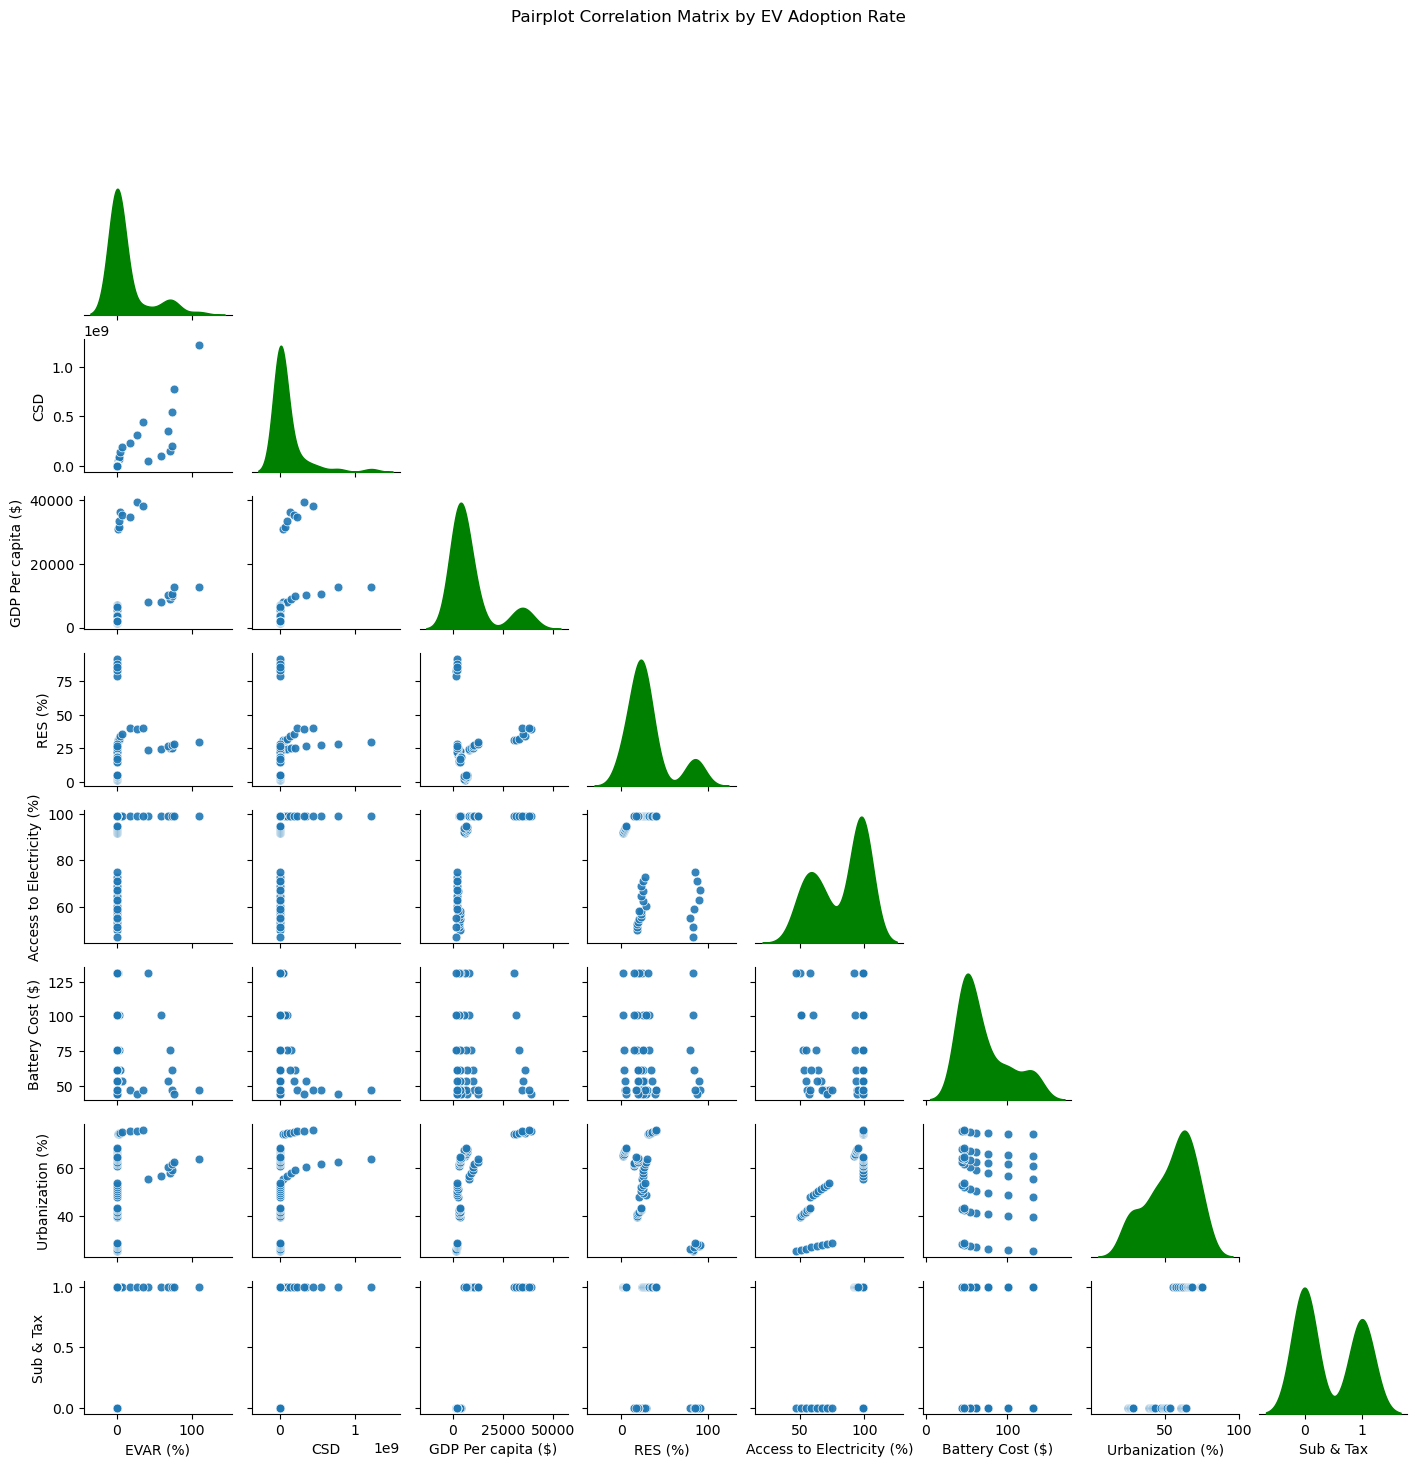

In [6]:
bins = [0, 20, 40, 60, 80, float('inf')]
labels = ['0-20', '20-40', '40-60', '60-80', '>80']

# Create a new column with the bin labels
#X_['EVAR (%)'] = pd.cut(X_['EVAR (%)'], bins=bins, labels=labels, right=False)

# Use a bright color palette
palette = sns.color_palette('bright', len(labels))

sns.pairplot(
    X_,
    diag_kind='kde',
    
    corner=True,
    palette=palette,
    plot_kws={'alpha': 0.9, 's': 40},
    diag_kws={'alpha': 1, 'fill': True, 'color': 'green'},
    height=1.8
    )

plt.subplots_adjust(top=0.9)
plt.suptitle('Pairplot Correlation Matrix by EV Adoption Rate', y=1.02)
plt.show()

In [7]:
X_.describe().round(2)

,EVAR (%),CSD,GDP Per capita ($),RES (%),Access to Electricity (%),Battery Cost ($),Urbanization (%),Sub & Tax
count,56.00,5.600000e+01,56.00,56.00,56.00,56.00,56.00,56.00
mean,12.16,8.795428e+07,8826.75,30.46,81.57,70.25,54.74,0.43
std,26.20,2.158386e+08,11115.63,24.57,19.49,29.28,15.18,0.50
min,0.00,2.422410e+03,1489.12,1.65,47.00,44.54,25.66,0.00
25%,0.09,8.368914e+04,2233.71,18.18,61.75,47.16,42.82,0.00
50%,0.20,3.338330e+05,3430.33,24.16,93.50,57.64,59.73,0.00
75%,2.80,5.235012e+07,8275.05,31.70,99.00,82.20,65.47,1.00
max,109.10,1.218917e+09,39180.38,91.46,99.00,131.00,75.46,1.00


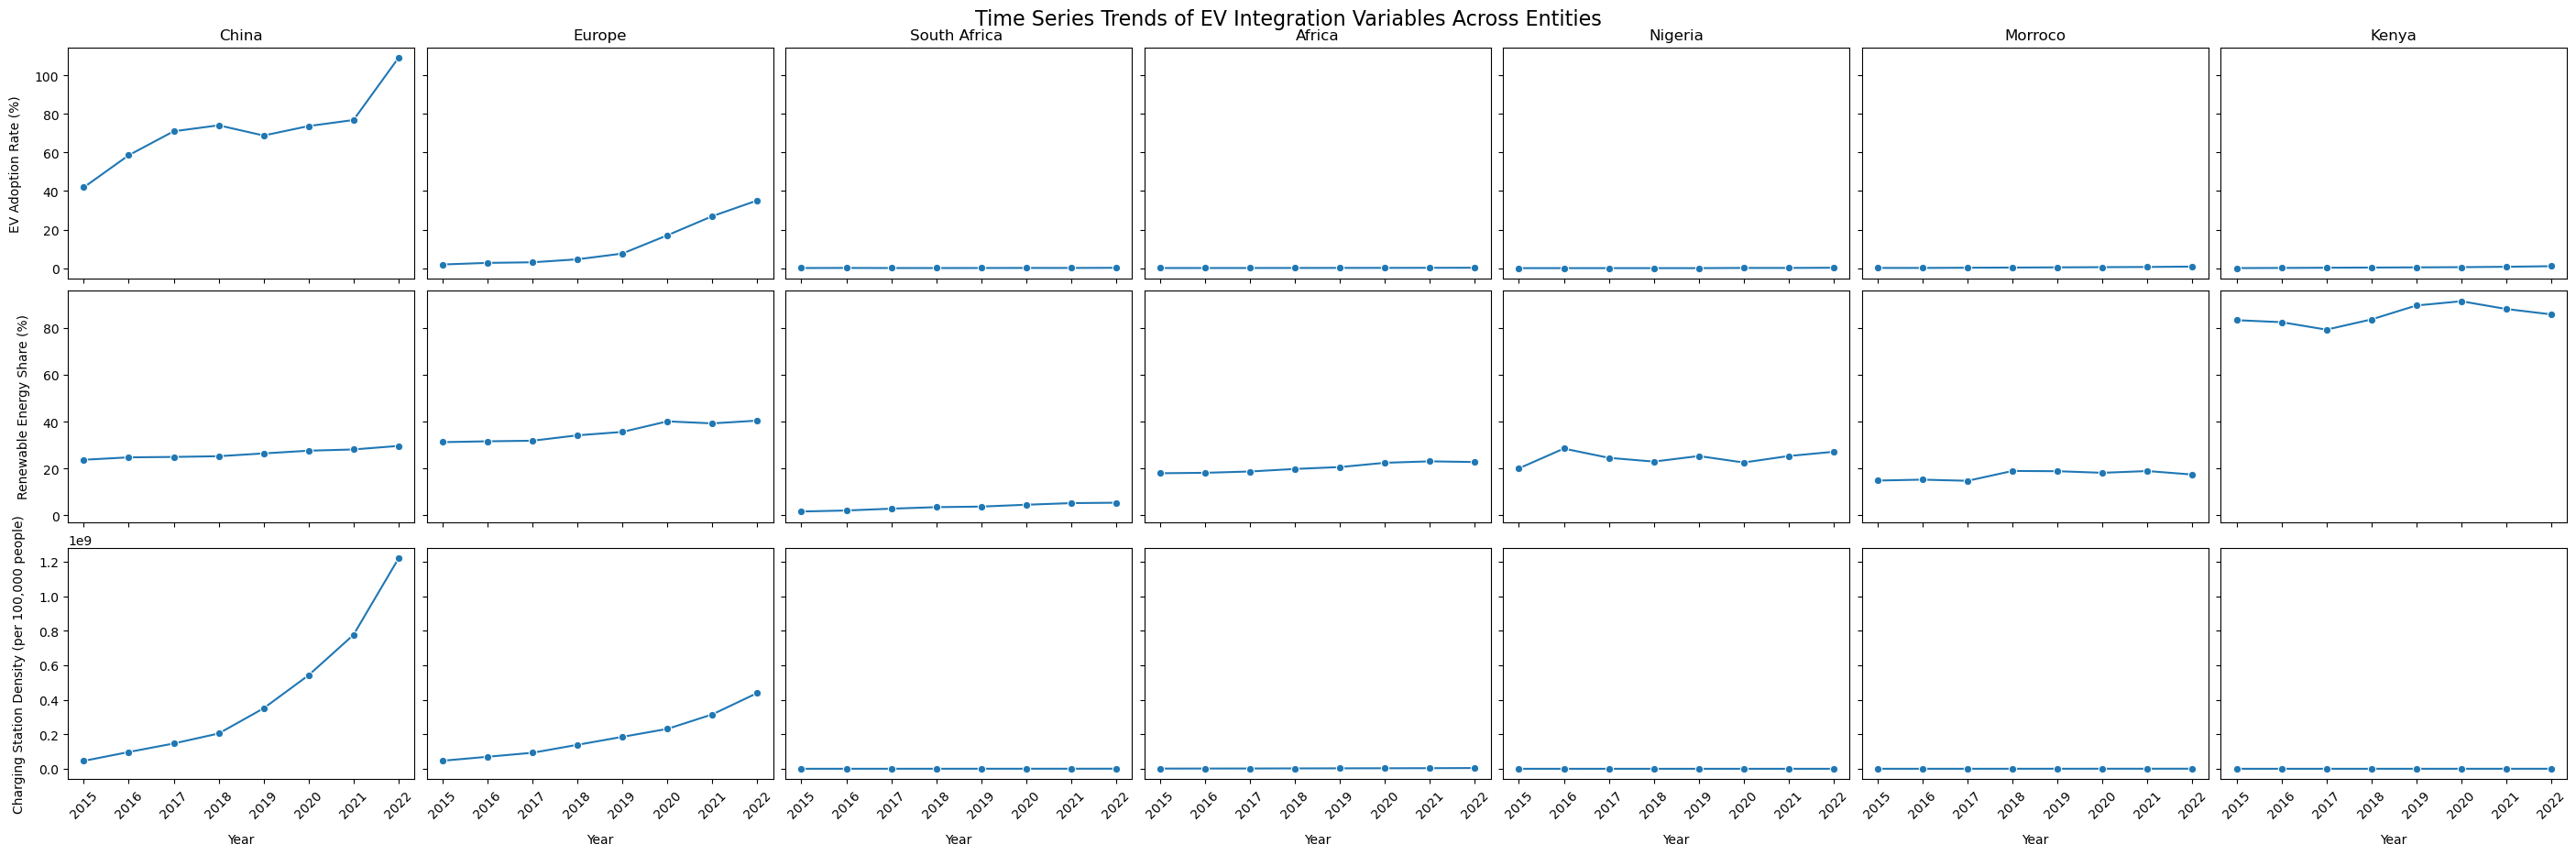

In [8]:

# Load your data (adjust the file path as needed)
data_for_plots = data.copy()

# Calculate Charging Station Density (CSD) if not already in the dataset
data_for_plots['CSD'] = data_for_plots['Charging infrastructures'] / data_for_plots['PD (Population/sqKM)']* 100000  # Chargers per 100,000 people

# List of variables to plot
variables = ['EVAR (%)', 'RES (%)', 'CSD']
variable_labels = {
    'EVAR (%)': 'EV Adoption Rate (%)',
    'RES (%)': 'Renewable Energy Share (%)',
     'CSD': 'Charging Station Density (per 100,000 people)'
}

# Unique entities
entities = data_for_plots['Entity'].unique()

# Set up the grid: rows = variables, columns = entities
n_vars = len(variables)
n_entities = len(entities)
fig, axes = plt.subplots(nrows=n_vars, ncols=n_entities, figsize=(n_entities * 4, n_vars * 3), 
                         sharex=True, sharey='row', constrained_layout=True)

# Plot each variable for each entity
for i, var in enumerate(variables):
    for j, entity in enumerate(entities):
        # Subset data for the current entity
        entity_data = data_for_plots[data_for_plots['Entity'] == entity]
        
        # Plot on the corresponding subplot
        ax = axes[i, j]
        sns.lineplot(x='Year', y=var, data=entity_data, ax=ax, marker='o')
        
        # Set titles and labels
        if i == 0:
            ax.set_title(entity, fontsize=12)
        if j == 0:
            ax.set_ylabel(variable_labels[var], fontsize=10, labelpad=10)
        ax.set_xlabel('Year' if i == n_vars - 1 else '', fontsize=10, labelpad=10)
        
        # Adjust tick labels for readability
        ax.tick_params(axis='x', rotation=45)

# Adjust layout and display
plt.suptitle('Time Series Trends of EV Integration Variables Across Entities', fontsize=16, y=1.02)
plt.show()
   

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=data['Entity']
)
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Linear Regression (Single Split, Scaled Data):
MSE: 17.09
MAE: 3.06
R²: 0.97


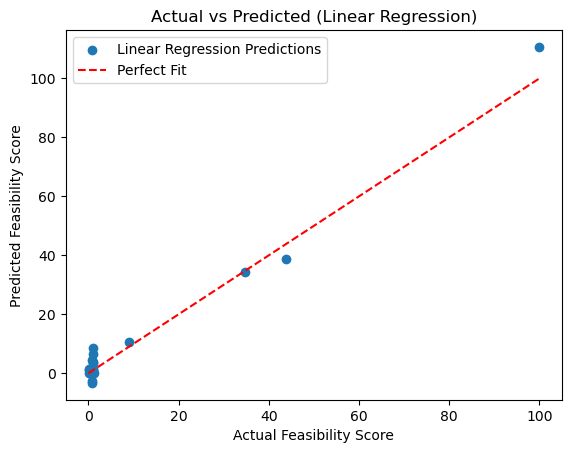

In [ ]:

# 1. Linear Regression
# Single-split evaluation (scaled data)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
print("Linear Regression (Single Split, Scaled Data):")
print(f"MSE: {mean_squared_error(y_test, lr_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, lr_pred):.2f}")
print(f"R²: {r2_score(y_test, lr_pred):.2f}")



# Feature Importance (using standardized coefficients)
lr.fit(X_train_scaled, y_train)  # Fit on scaled data for importance
lr_importance = np.abs(lr.coef_)
lr_importance = lr_importance / lr_importance.sum()  # Normalize to sum to 1
lr_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': lr_importance})
print("Linear Regression Feature Importance:")
print(lr_importance_df.sort_values(by='Importance', ascending=False))

# Plot Actual vs Predicted (Single Split)
plt.scatter(y_test, lr_pred, label='Linear Regression Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Fit')
plt.xlabel('Actual Feasibility Score')
plt.ylabel('Predicted Feasibility Score')
plt.title('Actual vs Predicted (Linear Regression)')
plt.legend()
plt.show()
#-------------------------------------------------------------------------------------------------------------------------

Baseline Random Forest (Single Split):
MSE: 119.30
MAE: 4.35
R²: 0.81

Tuned Random Forest:
Best Params: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
MSE: 121.50
MAE: 4.76
R²: 0.81

Feature Importance:
                     Feature  Importance
0                        CSD    0.910500
1         GDP Per capita ($)    0.039284
2                    RES (%)    0.020443
4           Battery Cost ($)    0.016769
5           Urbanization (%)    0.012728
6                  Sub & Tax    0.000155
3  Access to Electricity (%)    0.000119


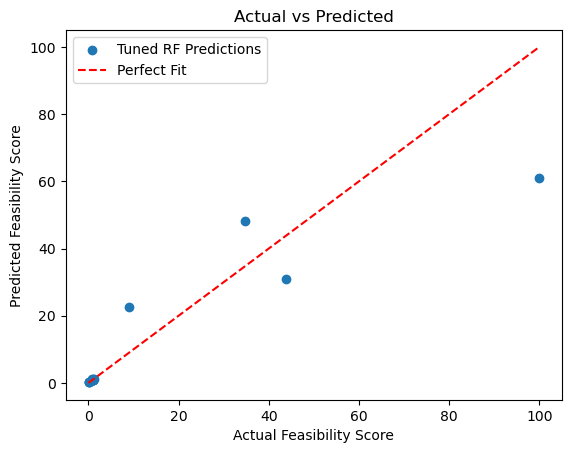

In [11]:

# 2. Random Forest Regressor
rf_base = RandomForestRegressor(n_estimators=300, max_depth=5, random_state=42)
rf_base.fit(X_train_scaled, y_train)
rf_pred = rf_base.predict(X_test_scaled)
print("Baseline Random Forest (Single Split):")
print(f"MSE: {mean_squared_error(y_test, rf_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, rf_pred):.2f}")
print(f"R²: {r2_score(y_test, rf_pred):.2f}")


# Tuned RF with GridSearchCV
rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_
print("\nTuned Random Forest:")
print(f"Best Params: {rf_grid.best_params_}")

# Evaluate tuned RF on test set
rf_tuned_pred = rf_best.predict(X_test_scaled)
print(f"MSE: {mean_squared_error(y_test, rf_tuned_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, rf_tuned_pred):.2f}")
print(f"R²: {r2_score(y_test, rf_tuned_pred):.2f}")



# Feature Importance
rf_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_best.feature_importances_})
print("\nFeature Importance:")
print(rf_importance.sort_values('Importance', ascending=False))


# Plot Actual vs Predicted (Tuned RF)
plt.scatter(y_test, rf_tuned_pred, label='Tuned RF Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Fit')
plt.xlabel('Actual Feasibility Score')
plt.ylabel('Predicted Feasibility Score')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()




#--------------------------------------------------------------------------------------------------------------------------

XGBoost (Single Split, Scaled Data):
MSE: 78.41
MAE: 3.35
R²: 0.88

Feature Importance:
                     Feature  Importance
0                        CSD    0.758163
1         GDP Per capita ($)    0.218538
2                    RES (%)    0.023203
4           Battery Cost ($)    0.000059
5           Urbanization (%)    0.000025
3  Access to Electricity (%)    0.000011
6                  Sub & Tax    0.000000


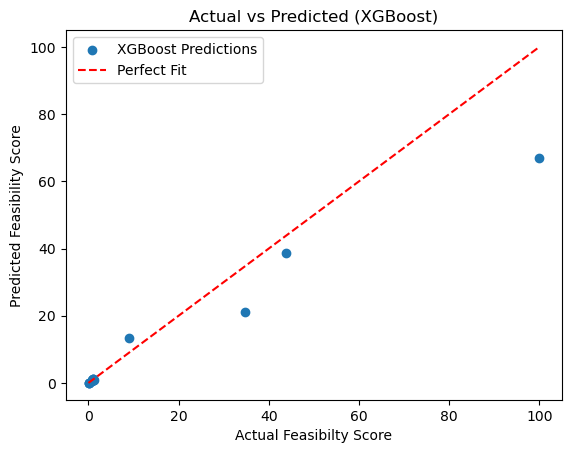

In [12]:

# 3. XGBoost Regressor
# 3. XGBoost
# Single-split evaluation (scaled data)
xgb = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)
print("XGBoost (Single Split, Scaled Data):")
print(f"MSE: {mean_squared_error(y_test, xgb_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred):.2f}")
print(f"R²: {r2_score(y_test, xgb_pred):.2f}")


# Feature Importance (from single-split model)
xgb.fit(X_train_scaled, y_train)  # Fit on full scaled data for importance
xgb_importance = pd.DataFrame({'Feature': X.columns, 'Importance': xgb.feature_importances_})
print("\nFeature Importance:")
print(xgb_importance.sort_values('Importance', ascending=False))

# Plot Actual vs Predicted (Single Split)
plt.scatter(y_test, xgb_pred, label='XGBoost Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Fit')
plt.xlabel('Actual Feasibilty Score')
plt.ylabel('Predicted Feasibility Score')
plt.title('Actual vs Predicted (XGBoost)')
plt.legend()
plt.show()

#---------------------------------------------------------------------------------------------------------------------------

In [ ]:

# 4. Neural Network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def create_nn_model():
    model = Sequential([
        Dense(4, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

nn = create_nn_model()
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
nn.fit(X_train_scaled, y_train, validation_split=0.3, epochs=1000, batch_size=4, verbose=0)
nn_pred = nn.predict(X_test_scaled, verbose=0).flatten()
print("Neurl Network (Single Split, Scaled Data):")
print(f"MSE: {mean_squared_error(y_test, nn_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, nn_pred):.2f}")
print(f"R²: {r2_score(y_test, nn_pred):.2f}")


c:\Users\nnsan\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neurl Network (Single Split, Scaled Data):
MSE: 4.82
MAE: 1.49
R²: 0.88


In [ ]:
# SHAP for Linear Regression
explainer_lr = shap.LinearExplainer(lr, X_train_scaled, feature_perturbation="interventional")
shap_values_lr = explainer_lr.shap_values(X_test_scaled)

# SHAP for Random Forest
explainer_rf = shap.TreeExplainer(rf_best)
shap_values_rf = explainer_rf.shap_values(X_test_scaled)

# SHAP for XGBoost
explainer = shap.TreeExplainer(xgb)
shap_values_xg = explainer.shap_values(X_test_scaled)

# SHAP for Neural Network

background = X_train_scaled[:min(50, len(X_train_scaled))]
test_subset = X_test_scaled[:min(10, len(X_test_scaled))]
explainer = shap.KernelExplainer(lambda x: nn.predict(x, verbose=0).flatten(), background)
shap_values_nn = explainer.shap_values(test_subset)


c:\Users\nnsan\AppData\Local\anaconda3\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


  0%|          | 0/10 [00:00<?, ?it/s]

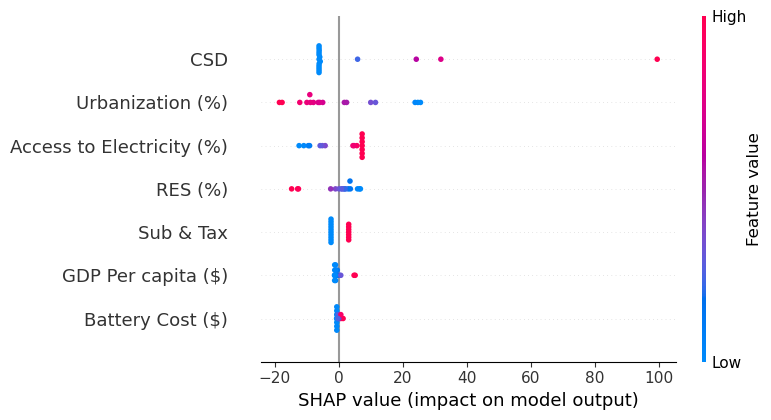

In [22]:
# Plot SHAP summary for Linear Regression
shap.summary_plot(shap_values_lr, X_test_scaled, feature_names=X.columns, show=False)



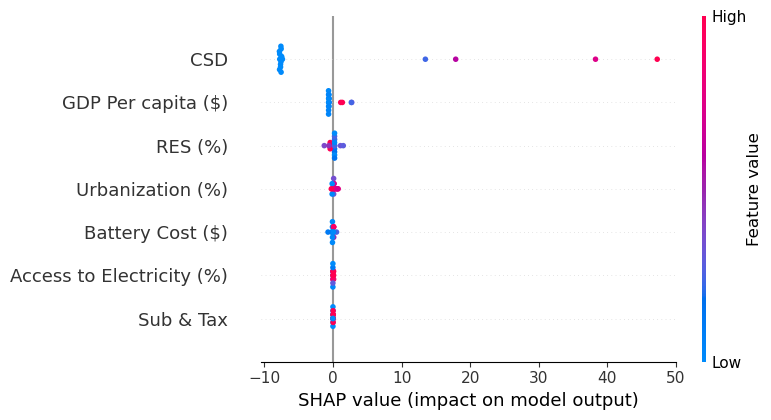

In [23]:
# Plot SHAP summary for Random Forest
shap.summary_plot(shap_values_rf, X_test_scaled, feature_names=X.columns, show=False)


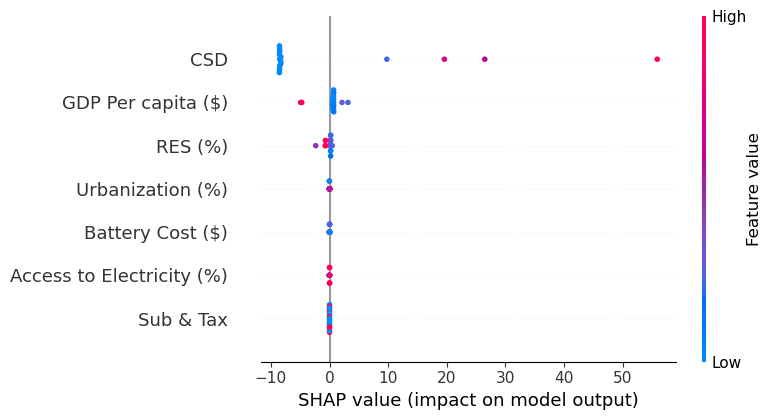

In [24]:

# Plot SHAP summary for XGBoost
shap.summary_plot(shap_values_xg, X_test_scaled, feature_names=X.columns, show=False)


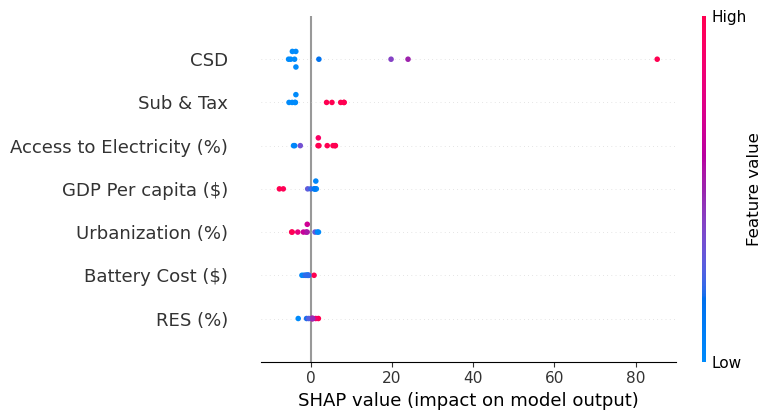

In [25]:

# Plot SHAP summary for Neural Network
shap.summary_plot(shap_values_nn, test_subset, feature_names=X.columns, show=False)

In [30]:
nn_importance = np.abs(shap_values_nn).mean(axis=0)
nn_importance = nn_importance / nn_importance.sum()

In [33]:

#variable importnace table
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Linear Regression': lr_importance,
    'Random Forest': rf_importance['Importance'],
    'XGBoost': xgb_importance['Importance'],
    'Neural Network': nn_importance
})
importance_df = importance_df.set_index('Feature')

# Normalize NN importance to sum to 1 for comparison

#-accuracy table for r2 score, MSE, MAE
accuracy_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network'],
    'R² Score': [r2_score(y_test, lr_pred), r2_score(y_test, rf_tuned_pred), r2_score(y_test, xgb_pred), r2_score(y_test, nn_pred)],
    'MSE': [mean_squared_error(y_test, lr_pred), mean_squared_error(y_test, rf_tuned_pred), mean_squared_error(y_test, xgb_pred), mean_squared_error(y_test, nn_pred)],
    'MAE': [mean_absolute_error(y_test, lr_pred), mean_absolute_error(y_test, rf_tuned_pred), mean_absolute_error(y_test, xgb_pred), mean_absolute_error(y_test, nn_pred)]
})
accuracy_df = accuracy_df.set_index('Model')

# Save the accuracy and importance dataframes to Excel
output_path = r"C:\Users\nnsan\Documents\Panel_Data_For Analysis.xlsx"  # Replace with your desired output path
with pd.ExcelWriter(output_path, engine='openpyxl', mode='a') as writer:
    accuracy_df.to_excel(writer, sheet_name='Model_Accuracy')
    importance_df.to_excel(writer, sheet_name='Feature_Importance')

# Print the accuracy and importance dataframes
print("\nModel Accuracy:")
print(accuracy_df)
print("\nFeature Importance:")
print(importance_df.sort_values(by='Random Forest', ascending=False))



Model Accuracy:
                   R² Score         MSE       MAE
Model                                            
Linear Regression  0.973392   17.088411  3.055215
Random Forest      0.810817  121.497380  4.757078
XGBoost            0.877907   78.410366  3.350450
Neural Network     0.992489    4.823476  1.491026

Feature Importance:
                           Linear Regression  Random Forest   XGBoost  \
Feature                                                                 
CSD                                 0.298727       0.910500  0.758163   
GDP Per capita ($)                  0.042797       0.039284  0.218538   
RES (%)                             0.119961       0.020443  0.023203   
Battery Cost ($)                    0.015573       0.016769  0.000059   
Urbanization (%)                    0.287471       0.012728  0.000025   
Sub & Tax                           0.059625       0.000155  0.000000   
Access to Electricity (%)           0.175846       0.000119  0.000011   

    

In [ ]:
# Plotting Feature Importance
importance_df.plot(kind='bar', figsize=(12, 6), title='Feature Importance Comparison')
plt.ylabel('Importance Score')  

plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

#acuracy metrics for taining and test data
print("\nTraining Data Accuracy:")
print(f"Linear Regression R²: {r2_score(y_train, lr.predict(X_train_scaled)):.2f}")
print(f"Random Forest R²: {r2_score(y_train, rf_best.predict(X_train_scaled)):.2f}")
print(f"XGBoost R²: {r2_score(y_train, xgb.predict(X_train_scaled)):.2f}")
print(f"Neural Network R²: {r2_score(y_train, nn.predict(X_train_scaled).flatten()):.2f}")
print(f"Linear Regression MSE: {mean_squared_error(y_train, lr.predict(X_train_scaled)):.2f}")
print(f"Random Forest MSE: {mean_squared_error(y_train, rf_best.predict(X_train_scaled)):.2f}")
print(f"XGBoost MSE: {mean_squared_error(y_train, xgb.predict(X_train_scaled)):.2f}")
print(f"Neural Network MSE: {mean_squared_error(y_train, nn.predict(X_train_scaled).flatten()):.2f}")
print(f"Linear Regression MAE: {mean_absolute_error(y_train, lr.predict(X_train_scaled)):.2f}")
print(f"Random Forest MAE: {mean_absolute_error(y_train, rf_best.predict(X_train_scaled)):.2f}")
print(f"XGBoost MAE: {mean_absolute_error(y_train, xgb.predict(X_train_scaled)):.2f}")

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['CSD', 'GDP Per capita ($)', 'RES (%)',
                                      'Access to Electricity (%)', 'Battery Cost ($)',
                                      'Urbanization (%)', 'Sub & Tax'])
    ]
)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=300, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
}

# Create a function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, mae, r2



# Create a pipeline for each model
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

# Evaluate each pipeline
results = []
for name, pipeline in pipelines.items():
    # Convert scaled arrays back to DataFrames with column names
    X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
    
    mse, mae, r2 = evaluate_model(pipeline, X_train_df, X_test_df, y_train, y_test)
    results.append({'Model': name, 'MSE': mse, 'MAE': mae, 'R²': r2})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print results
print(results_df)



               Model         MSE       MAE        R²
0  Linear Regression   17.088411  3.055215  0.973392
1      Random Forest  119.302159  4.350705  0.814235
2            XGBoost   78.410366  3.350450  0.877907


In [ ]:
# Ensure all arrays have the same length
variables = X.columns  # Features used in the models
nn_importance_resized = nn_importance[:len(variables)]  # Resize nn_importance to match the number of features

# Create Feature Importance Table
importance_df = pd.DataFrame({
    'Variables': variables,
    'Linear Regression': lr_importance_df['Importance'],
    'Random Forest': rf_importance['Importance'],
    'XGBoost': xgb_importance['Importance'],
    'Neural Network': nn_importance_resized
})

# Format for display
importance_df = importance_df.round(2)
print("\nFeature Importance Table for All Models:")
print(importance_df.to_string(index=False))

# Save to CSV
importance_df.to_csv('feature_importance_table_all_models_u.csv', index=False)

In [ ]:
def createe_nn_model():
    model = Sequential([
        Dense(4, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

nn = createe_nn_model()
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
nn.fit(X_train_scaled, y_train, validation_split=0.3, epochs=1000, batch_size=4, verbose=0)
nn_pred = nn.predict(X_test_scaled, verbose=0).flatten()
print("\nNeural Network (Single Split):")
print(f"R²: {r2_score(y_test, nn_pred):.2f}")


c:\Users\nnsan\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Neural Network (Single Split):
R²: 0.99


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# SHAP for NN
background = X_train_scaled[:min(50, len(X_train_scaled))]
test_subset = X_test_scaled[:min(10, len(X_test_scaled))]
explainer = shap.KernelExplainer(lambda x: nn.predict(x, verbose=0).flatten(), background)
shap_valuess = explainer.shap_values(test_subset)
nn_importance = np.abs(shap_valuess).mean(axis=0)
# Normalize NN importance to sum to 1 for comparison
nn_importance = nn_importance / nn_importance.sum()

  0%|          | 0/10 [00:00<?, ?it/s]

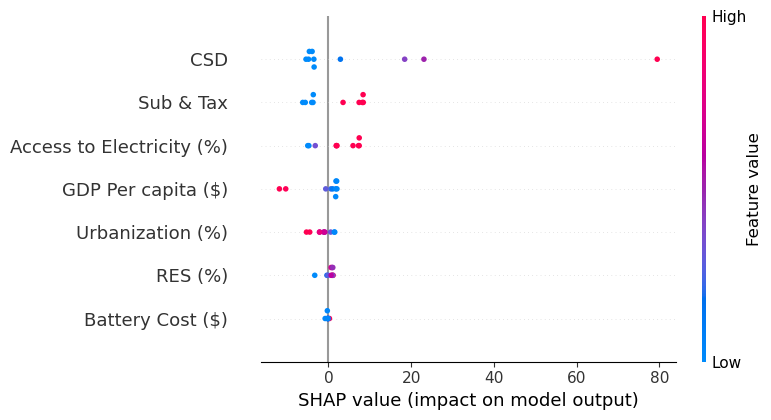

In [ ]:
shap.summary_plot(shap_valuess, test_subset, feature_names=X.columns, show=True)

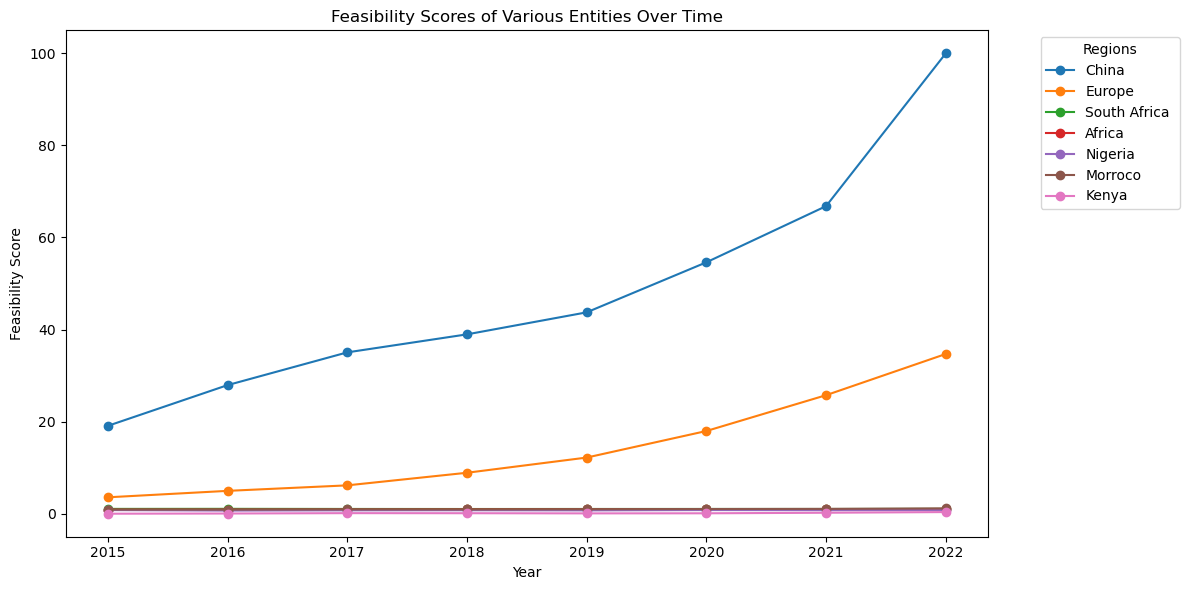

In [ ]:
# Group data by Entity and plot Feasibility Scores
plt.figure(figsize=(12, 6))
for entity in data['Entity'].unique():
    entity_data = data[data['Entity'] == entity]
    plt.plot(entity_data['Year'], entity_data['Feasibility_Score'], marker='o', label=entity)

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Feasibility Score')
plt.title('Feasibility Scores of Various Entities Over Time')
plt.legend(title='Regions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on the EVAR (%) column
adf_result = adfuller(entity_data['EVAR (%)'])

# Print the results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: 1.7320508075688636
p-value: 0.9982042849867908
Critical Values:
   1%: -6.045114
   5%: -3.9292800000000003
   10%: -2.98681


In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import arma_order_select_ic

# Use arma_order_select_ic to determine the optimal lag order
optimal_lag = arma_order_select_ic(entity_data['EVAR (%)'], ic='aic', trend='c', max_ar=5, max_ma=5)

# Print the optimal lag order
print("Optimal lag order (AR, MA):", optimal_lag.aic_min_order)

c:\Users\nnsan\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\nnsan\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\nnsan\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nnsan\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum L

Optimal lag order (AR, MA): (2, 1)


c:\Users\nnsan\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Variance Inflation Factor (VIF):
                   Variable       VIF
0                   RES (%)  1.712527
1            GDP_Per_capita  2.427397
2          Urbanization (%)  2.880521
3  Charging_Station_Density  1.377957
                          PanelOLS Estimation Summary                           
Dep. Variable:               EVAR (%)   R-squared:                        0.5427
Estimator:                   PanelOLS   R-squared (Between):             -2.9542
No. Observations:                  56   R-squared (Within):               0.5427
Date:                Sun, Apr 13 2025   R-squared (Overall):             -2.6180
Time:                        19:12:41   Log-likelihood                   -174.37
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      27.887
Entities:                           7   P-value                           0.0000
Avg Obs:                       8.0000   Distribu

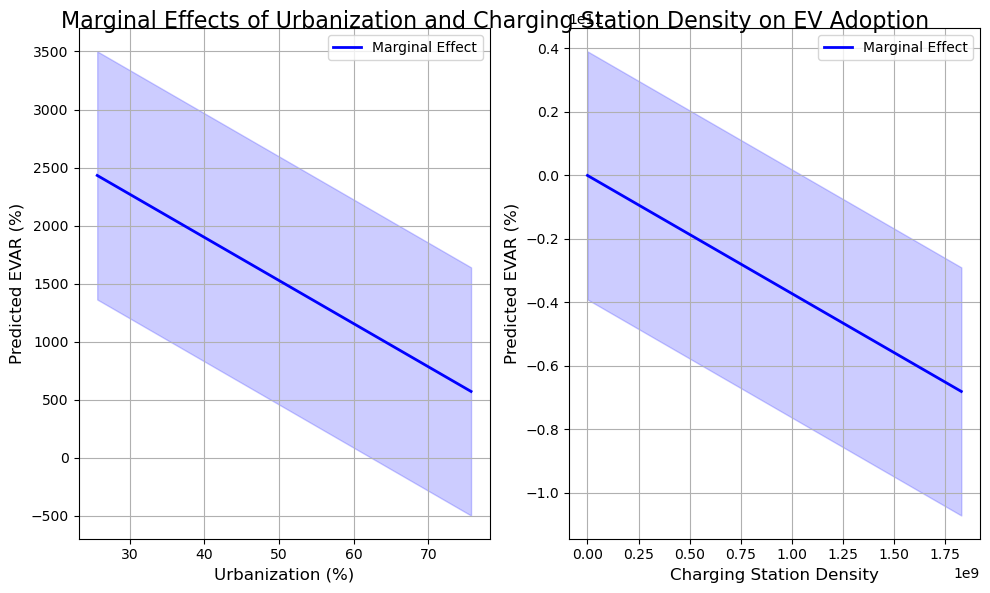

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels import PanelOLS
import matplotlib.pyplot as plt

# Load data
df = pd.read_excel(r"C:\Users\nnsan\Documents\Panel_Data_For Analy_2015.xlsx", sheet_name="Sheet1")

# Clean Charging Station Density (remove formulas)
df['Charging Station Density'] = df['Charging infrastructures'] / df['PD (Population/sqKM)'] * 100000

# Set panel structure
df = df.set_index(['Entity', 'Year'])

# Check for multicollinearity using Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare the independent variables
independent_vars = df.rename(columns={
    'GDP Per capita ($)': 'GDP_Per_capita',
    'Urbanization (%)': 'Urbanization (%)',
    'Charging Station Density': 'Charging_Station_Density'
})[['RES (%)', 'GDP_Per_capita', 'Urbanization (%)', 'Charging_Station_Density']]

# Drop rows with NaN or infinite values
independent_vars = independent_vars.replace([np.inf, -np.inf], np.nan).dropna()

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data['Variable'] = independent_vars.columns
vif_data['VIF'] = [variance_inflation_factor(independent_vars.values, i) for i in range(independent_vars.shape[1])]
print("Variance Inflation Factor (VIF):")
print(vif_data)

# Ensure the dependent variable and independent variables have no NaN or infinite values
df_cleaned = df.rename(columns={
    'GDP Per capita ($)': 'GDP_Per_capita',
    'Urbanization (%)': 'Urbanization (%)',
    'Charging Station Density': 'Charging_Station_Density'
}).replace([np.inf, -np.inf], np.nan).dropna(subset=['EVAR (%)', 'RES (%)', 'GDP_Per_capita', 'Urbanization (%)', 'Charging_Station_Density'])

# Update the formula to exclude dropped variables
fe_model = PanelOLS.from_formula(
    '`EVAR (%)` ~ 1 + `RES (%)` + GDP_Per_capita + EntityEffects',
    data=df_cleaned
).fit(cov_type='clustered', cluster_entity=True)
      

print(fe_model.summary)

# Generate predicted values
urban_range = np.linspace(df['Urbanization (%)'].min(), df['Urbanization (%)'].max(), 100)
csd_range = np.linspace(df['Charging Station Density'].min(), df['Charging Station Density'].max(), 100)
predict_data = pd.DataFrame({
    'Urbanization (%)': urban_range,
    'GDP_Per_capita': df['GDP Per capita ($)'].mean(),
    'RES (%)': df['RES (%)'].mean()
    #'Charging_Station_Density': df['Charging Station Density'].mean()
})
predict_data2 = pd.DataFrame({
    'Charging_Station_Density': csd_range,
   # 'Urbanization (%)': df['Urbanization (%)'].mean(),
    'GDP_Per_capita': df['GDP Per capita ($)'].mean(),
    'RES (%)': df['RES (%)'].mean()
})

# Add a MultiIndex to match the PanelOLS requirements
predict_data['Entity'] = 'Synthetic_Entity'  # Add a synthetic entity
predict_data['Year'] = range(1, len(predict_data) + 1)  # Add synthetic years
predict_data = predict_data.set_index(['Entity', 'Year'])

# Predict EVAR
predict_data = sm.add_constant(predict_data)
# Add a constant term for the intercept
predict_data = sm.add_constant(predict_data)

# Ensure the MultiIndex structure matches the PanelOLS requirements
predict_data['Entity'] = 'Synthetic_Entity'  # Add a synthetic entity
predict_data['Year'] = range(1, len(predict_data) + 1)  # Add synthetic years
predict_data = predict_data.set_index(['Entity', 'Year'])

# Predict EVAR
predict_data['EVAR_pred'] = fe_model.predict(predict_data)
#----
# Add a MultiIndex to match the PanelOLS requirements
predict_data2['Entity'] = 'Synthetic_Entity'  # Add a synthetic entity
predict_data2['Year'] = range(1, len(predict_data2) + 1)  # Add synthetic years
predict_data2 = predict_data2.set_index(['Entity', 'Year'])

# Predict EVAR
predict_data2 = sm.add_constant(predict_data2)
# Add a constant term for the intercept
predict_dat2 = sm.add_constant(predict_data2)

# Ensure the MultiIndex structure matches the PanelOLS requirements
predict_data2['Entity'] = 'Synthetic_Entity'  # Add a synthetic entity
predict_data2['Year'] = range(1, len(predict_data2) + 1)  # Add synthetic years
predict_data2 = predict_data2.set_index(['Entity', 'Year'])

# Predict EVAR
predict_data2['EVAR_pred'] = fe_model.predict(predict_data2)

# Plot
fig, ax = plt.subplots(1,2,figsize=(10, 6))
ax[0].plot(urban_range, predict_data['EVAR_pred'], color='blue', lw=2, label='Marginal Effect')
ax[0].fill_between(urban_range, 
                 predict_data['EVAR_pred'] - 1.96*predict_data['EVAR_pred'].std(),
                 predict_data['EVAR_pred'] + 1.96*predict_data['EVAR_pred'].std(),
                 alpha=0.2, color='blue')
#ax[0].set_title("Marginal Effect of Urbanization on EV Adoption (FE Model)", fontsize=14)
ax[0].set_xlabel("Urbanization (%)", fontsize=12)
ax[0].set_ylabel("Predicted EVAR (%)", fontsize=12)
ax[0].legend()
ax[0].grid(True)
ax[1].plot(csd_range, predict_data2['EVAR_pred'], color='blue', lw=2, label='Marginal Effect')
ax[1].fill_between(csd_range, 
                 predict_data2['EVAR_pred'] - 1.96*predict_data2['EVAR_pred'].std(),
                 predict_data2['EVAR_pred'] + 1.96*predict_data2['EVAR_pred'].std(),
                 alpha=0.2, color='blue')
#ax[1].set_title("Marginal Effect of Charging Station Density on EV Adoption (FE Model)", fontsize=14)
ax[1].set_xlabel("Charging Station Density", fontsize=12)
ax[1].set_ylabel("Predicted EVAR (%)", fontsize=12)
ax[1].legend()
ax[1].grid(True)
plt.tight_layout()
plt.suptitle("Marginal Effects of Urbanization and Charging Station Density on EV Adoption", fontsize=16)
plt.savefig('marginal_effects.png', dpi=300, bbox_inches='tight')
plt.show()
# plt.figure(figsize=(10, 6))
# plt.plot(urban_range, predict_data['EVAR_pred'], color='blue', lw=2, label='Marginal Effect')
# plt.fill_between(urban_range, 
#                  predict_data['EVAR_pred'] - 1.96*predict_data['EVAR_pred'].std(),
#                  predict_data['EVAR_pred'] + 1.96*predict_data['EVAR_pred'].std(),
#                  alpha=0.2, color='blue')
# plt.title("Marginal Effect of Urbanization on EV Adoption (FE Model)", fontsize=14)
# plt.xlabel("Urbanization (%)", fontsize=12)
# plt.ylabel("Predicted EVAR (%)", fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.savefig('urbanization_marginal_effect.png', dpi=300, bbox_inches='tight')
# plt.show()

